Rajendra Singh (111601017)

To view below notebook in colab click here
https://colab.research.google.com/drive/1MXy_9XRxPZBn2MN1axti6YcvtRoVpAFt

# ============================= Adding data directory ====================

In [77]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# !cp "gdrive/My Drive/DeepLearning/Assign3/ques2/data" -r data/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# ============================= Imports ====================

In [146]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import os
import multiprocessing
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.spatial.distance import cdist

import keras
from keras.models import Sequential
from keras.layers import LSTM, GRU, Embedding, Dense, Flatten, Dropout,SimpleRNN,Reshape
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.datasets import imdb

from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from time import *

import gensim
from gensim import corpora, models, similarities
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models.doc2vec import TaggedDocument


import os
tf.__version__

'1.15.0'

In [0]:
# (x_train, y_train), (x_test, y_test) = imdb.load_data(path="imdb.npz")

# ============================= Load data ===================

In [80]:
import pandas as pd
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer('[a-zA-Z]{2,}')
train_df = pd.read_csv('data/train.txt', delimiter='\n', header=None, names=['X'])
test_df = pd.read_csv('data/test.txt', delimiter='\n', header=None, names=['X'])

col_y = ([1] * 12500) + ([0] * 12500)
train_df.insert (1, 'Y', col_y, True)
test_df.insert (1, 'Y', col_y, True)

print (len(train_df))
print (len(test_df))
print (train_df.head())
print (test_df.tail())

25000
25000
                                                   X  Y
0  Bromwell High is a cartoon comedy. It ran at t...  1
1  Homelessness (or Houselessness as George Carli...  1
2  Brilliant over-acting by Lesley Ann Warren. Be...  1
3  This is easily the most underrated film inn th...  1
4  This is not the typical Mel Brooks film. It wa...  1
                                                       X  Y
24995  I occasionally let my kids watch this garbage ...  0
24996  When all we have anymore is pretty much realit...  0
24997  The basic genre is a thriller intercut with an...  0
24998  Four things intrigued me as to this film - fir...  0
24999  David Bryce's comments nearby are exceptionall...  0


# ============================= Preprocess data ===================

In [81]:
import string
import nltk
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer('[a-zA-Z]{2,}')

def preprocess (text):
    tokens = tokenizer.tokenize(text)
    tokens = [word.lower() for word in tokens]
    return (" ".join(tokens))
    
train_df['X'] = train_df.apply(lambda row: preprocess(row['X']), axis=1)
test_df['X'] = test_df.apply(lambda row: preprocess(row['X']), axis=1)
print (train_df.head())

                                                   X  Y
0  bromwell high is cartoon comedy it ran at the ...  1
1  homelessness or houselessness as george carlin...  1
2  brilliant over acting by lesley ann warren bes...  1
3  this is easily the most underrated film inn th...  1
4  this is not the typical mel brooks film it was...  1


In [82]:
encoded_train_df = train_df.copy(deep=True)
encoded_test_df = test_df.copy(deep=True)

vocab = {}
k = 1

def encode (text):
    global k
    words = text.split()
    code = []
    for word in words:
        if word not in vocab:
            vocab[word] = k
            k += 1
        code.append(vocab[word])

    if len(code) > 200:
        code = code[:200]
    code = code + [0] * (200 - len(code))
    return code

encoded_train_df['X'] = encoded_train_df.apply(lambda row: encode(row['X']), axis=1)
encoded_test_df['X'] = encoded_test_df.apply(lambda row: encode(row['X']), axis=1)

print (encoded_train_df.head())

sample = encoded_train_df.iloc[0]['X']
print ('Sample padded sequence:', sample)

vocab_size = len(vocab)
print ('vocab_size:', vocab_size)

from sklearn.model_selection import train_test_split
encoded_train_df, encoded_val_df = train_test_split(encoded_train_df, test_size=0.2)

                                                   X  Y
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  1
1  [87, 88, 89, 12, 90, 91, 92, 93, 94, 95, 96, 9...  1
2  [287, 288, 289, 203, 214, 215, 216, 290, 291, ...  1
3  [282, 3, 356, 9, 116, 357, 283, 358, 9, 164, 3...  1
4  [282, 3, 236, 9, 405, 163, 164, 283, 6, 406, 3...  1
Sample padded sequence: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 12, 20, 21, 22, 23, 9, 24, 25, 26, 27, 28, 29, 30, 1, 2, 31, 3, 32, 33, 28, 34, 35, 3, 20, 9, 36, 28, 37, 38, 9, 39, 40, 41, 42, 43, 44, 45, 46, 47, 20, 48, 9, 49, 50, 9, 51, 52, 53, 54, 27, 50, 9, 55, 56, 57, 46, 40, 58, 59, 9, 60, 23, 61, 62, 63, 64, 28, 65, 66, 9, 17, 67, 68, 8, 2, 69, 70, 71, 72, 28, 73, 74, 50, 75, 20, 62, 76, 28, 1, 2, 77, 30, 78, 79, 50, 21, 80, 81, 30, 1, 2, 3, 82, 83, 84, 85, 30, 6, 86, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

# ============================= Parameters ===================

In [0]:
lr=1e-4
batch_size=256
epochs=10
# list of param to store result of various models
TotalNoPara=[0]*7
TrainingTime=[0]*7
TrainingAccuracy = [0]*7
ValidationAccuracy = [0]*7
TestAccuracy = [0]*7

# ============================= Data formating ===================

In [0]:
x_train = np.array(encoded_train_df['X'].tolist())
y_train = np.array(encoded_train_df['Y'].tolist())
x_val = np.array(encoded_val_df['X'].tolist())
y_val = np.array(encoded_val_df['Y'].tolist())
x_test = np.array(encoded_test_df['X'].tolist())
y_test = np.array(encoded_test_df['Y'].tolist())

# ============================= Create Helper Functions ===================

In [0]:
#=========================== lets create model =================#
def createModel(flag, NoLayers=1, word2vec=0,input_size=1, num_words=100000,embedding_size=128):
    print('NoLayers:',NoLayers,"\n")
    model = Sequential()
    if word2vec==0:
      model.add(Embedding(input_dim=num_words, output_dim=embedding_size,input_length=200))
    else:
      pass
      # model.add(Dense(input_size, input_shape=(input_size,)))
      # model.add(Flatten(data_format=None))

    for j in range(0,NoLayers):
      if flag==1:
        if j!=(NoLayers-1):
          model.add(SimpleRNN(200, activation='tanh',return_sequences=True))
        else:
          model.add(SimpleRNN(200, activation='tanh'))
      elif flag==2:
        model.add(LSTM(200, activation='tanh', recurrent_activation='tanh'))
      elif flag==3:
        model.add(GRU(200, activation='relu', recurrent_activation='relu'))
      # model.add(Reshape((1,3)))
    model.add(Dense(1, activation='sigmoid'))
    return model


# ===================== Function to train model ================
def trainModel(i,model,lr):
  print("\n----------------- ", "Training Starts", " ------------------------------\n")
  model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(lr=lr), metrics=['accuracy'])
  es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=1) #early stop if validation loss increases 
  mc = ModelCheckpoint('best_Model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
  tempt = time()
  history =  model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, workers=4, verbose=1, validation_data=(x_val, y_val), callbacks=[es, mc])
  
  tempt = time() - tempt
  TrainingTime[i]=tempt
  print("\n----------------- ", "Training Ends", " ------------------------------\n")
  print("\n----------------------- Time ---------------------------\n")
  print("\nTraining time(sec): ", tempt,"\n")

  print("\n----------------------- Plots ---------------------------\n")
  # Plot training & validation accuracy values
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  
  model = load_model('best_Model.h5')
  print("\n----------------- ", "Model Summury", " ------------------------------\n")
  print(model.summary())
  return model, tempt


# ===================== Funtion to evaluate model ================
def evalModel(i,model):
  score = model.evaluate(x_test, y_test, verbose=0) #evaluating on test set
  print("\n------------------------- Evaluation --------------------------\n")
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])
  TestAccuracy[i] = score[1]
  TrainingAccuracy[i] = model.evaluate(x_train, y_train, verbose=0)[1]
  ValidationAccuracy[i] = model.evaluate(x_val, y_val, verbose=0)[1]
  TotalNoPara[i] = model.count_params()
  return score[0], score[1]

# ============================= Model 1 ========================


-----------------  Training Starts  ------------------------------

Train on 20000 samples, validate on 5000 samples
Epoch 1/2
20000/20000 [==============================] - 73s 4ms/step - loss: 0.6934 - acc: 0.5147 - val_loss: 0.6947 - val_acc: 0.4970

Epoch 00001: val_acc improved from -inf to 0.49700, saving model to best_Model.h5
Epoch 2/2
20000/20000 [==============================] - 70s 4ms/step - loss: 0.6865 - acc: 0.5475 - val_loss: 0.6960 - val_acc: 0.5032

Epoch 00002: val_acc improved from 0.49700 to 0.50320, saving model to best_Model.h5

-----------------  Training Ends  ------------------------------


----------------------- Time ---------------------------


Training time(sec):  148.70033192634583 


----------------------- Plots ---------------------------



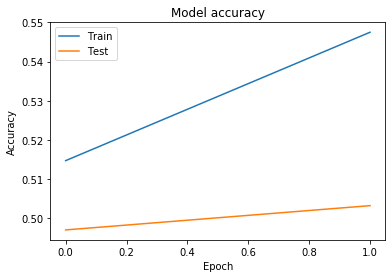

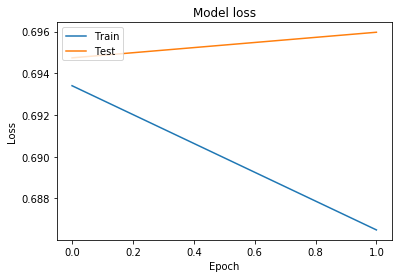


-----------------  Model Summury  ------------------------------

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 200, 128)          12800000  
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 200)               65800     
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 201       
Total params: 12,866,001
Trainable params: 12,866,001
Non-trainable params: 0
_________________________________________________________________
None

------------------------- Evaluation --------------------------

Test loss: 0.6923234342956543
Test accuracy: 0.52432


In [106]:
epochs=2
#================== Create model ================
model =  createModel(1)
#================== Train model ================
model,_ = trainModel(1,model,lr)
#================== eval model ================
loss_ci, acc_ci = evalModel(1,model)

# ============================= Model 2 ========================


-----------------  Training Starts  ------------------------------

Train on 20000 samples, validate on 5000 samples
Epoch 1/2
20000/20000 [==============================] - 214s 11ms/step - loss: 0.6931 - acc: 0.5025 - val_loss: 0.6932 - val_acc: 0.4896

Epoch 00001: val_acc improved from -inf to 0.48960, saving model to best_Model.h5
Epoch 2/2
20000/20000 [==============================] - 210s 11ms/step - loss: 0.6931 - acc: 0.5026 - val_loss: 0.6932 - val_acc: 0.4896

Epoch 00002: val_acc did not improve from 0.48960

-----------------  Training Ends  ------------------------------


----------------------- Time ---------------------------


Training time(sec):  429.553382396698 


----------------------- Plots ---------------------------



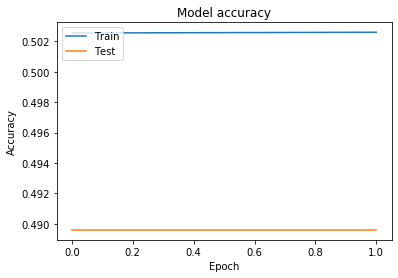

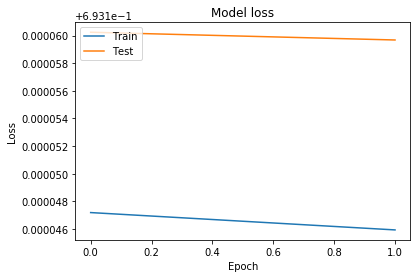


-----------------  Model Summury  ------------------------------

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 200, 128)          12800000  
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               263200    
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 201       
Total params: 13,063,401
Trainable params: 13,063,401
Non-trainable params: 0
_________________________________________________________________
None

------------------------- Evaluation --------------------------

Test loss: 0.6931473178100586
Test accuracy: 0.5


In [107]:
#================== Create model ================
model =  createModel(2)
#================== Train model ================
model,_ = trainModel(2,model,lr)
#================== eval model ================
loss_ci, acc_ci = evalModel(2,model)

# ============================= Model 3 ========================


-----------------  Training Starts  ------------------------------

Train on 20000 samples, validate on 5000 samples
Epoch 1/2
20000/20000 [==============================] - 162s 8ms/step - loss: 0.6931 - acc: 0.5061 - val_loss: 0.6932 - val_acc: 0.5032

Epoch 00001: val_acc improved from -inf to 0.50320, saving model to best_Model.h5
Epoch 2/2
20000/20000 [==============================] - 168s 8ms/step - loss: 0.6926 - acc: 0.5299 - val_loss: 0.6932 - val_acc: 0.4906

Epoch 00002: val_acc did not improve from 0.50320

-----------------  Training Ends  ------------------------------


----------------------- Time ---------------------------


Training time(sec):  336.3041865825653 


----------------------- Plots ---------------------------



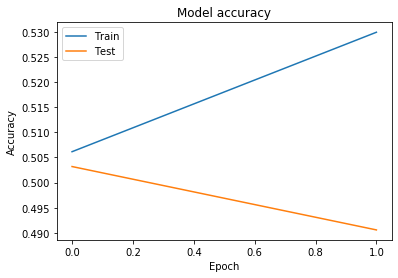

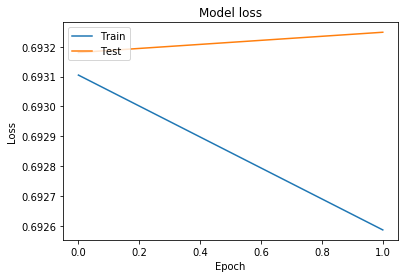


-----------------  Model Summury  ------------------------------

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 200, 128)          12800000  
_________________________________________________________________
gru_19 (GRU)                 (None, 200)               197400    
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 201       
Total params: 12,997,601
Trainable params: 12,997,601
Non-trainable params: 0
_________________________________________________________________
None

------------------------- Evaluation --------------------------

Test loss: 0.6931666491699219
Test accuracy: 0.50116


In [108]:
#================== Create model ================
model =  createModel(3)
#================== Train model ================
model,_ = trainModel(3,model,lr)
#================== eval model ================
loss_ci, acc_ci = evalModel(3,model)

# ============================= Model 4 ========================
Q. Which model best 1-3?
=> Model 1 is best.

Q. Why this model is best?
=> Because it maximum test accuracy and minimum loss    among all other model.

Continuing with best model with 2 layer of RNN

NoLayers: 2 


-----------------  Training Starts  ------------------------------

Train on 20000 samples, validate on 5000 samples
Epoch 1/2
20000/20000 [==============================] - 124s 6ms/step - loss: 0.6994 - acc: 0.5031 - val_loss: 0.7009 - val_acc: 0.5110

Epoch 00001: val_acc improved from -inf to 0.51100, saving model to best_Model.h5
Epoch 2/2
20000/20000 [==============================] - 119s 6ms/step - loss: 0.6738 - acc: 0.5627 - val_loss: 0.6851 - val_acc: 0.5466

Epoch 00002: val_acc improved from 0.51100 to 0.54660, saving model to best_Model.h5

-----------------  Training Ends  ------------------------------


----------------------- Time ---------------------------


Training time(sec):  250.07916021347046 


----------------------- Plots ---------------------------



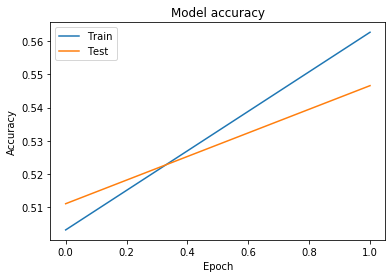

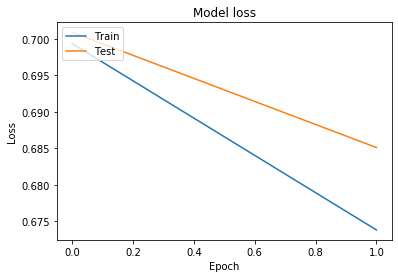


-----------------  Model Summury  ------------------------------

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_47 (Embedding)     (None, 200, 128)          12800000  
_________________________________________________________________
simple_rnn_35 (SimpleRNN)    (None, 200, 200)          65800     
_________________________________________________________________
simple_rnn_36 (SimpleRNN)    (None, 200)               80200     
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 201       
Total params: 12,946,201
Trainable params: 12,946,201
Non-trainable params: 0
_________________________________________________________________
None

------------------------- Evaluation --------------------------

Test loss: 0.6857225845718384
Test accuracy: 0.54384


In [139]:
#================== Create model ================
model =  createModel(1,2)
#================== Train model ================
model,_ = trainModel(4,model,lr)
#================== eval model ================
loss_ci, acc_ci = evalModel(4,model)

# ============================= Model 5 ========================
Continuing with best model with 3 layer of RNN

NoLayers: 3 


-----------------  Training Starts  ------------------------------

Train on 20000 samples, validate on 5000 samples
Epoch 1/2
20000/20000 [==============================] - 186s 9ms/step - loss: 0.7073 - acc: 0.5007 - val_loss: 0.6950 - val_acc: 0.5068

Epoch 00001: val_acc improved from -inf to 0.50680, saving model to best_Model.h5
Epoch 2/2
20000/20000 [==============================] - 190s 10ms/step - loss: 0.6733 - acc: 0.5688 - val_loss: 0.7114 - val_acc: 0.5048

Epoch 00002: val_acc did not improve from 0.50680
Epoch 00002: early stopping

-----------------  Training Ends  ------------------------------


----------------------- Time ---------------------------


Training time(sec):  386.42880868911743 


----------------------- Plots ---------------------------



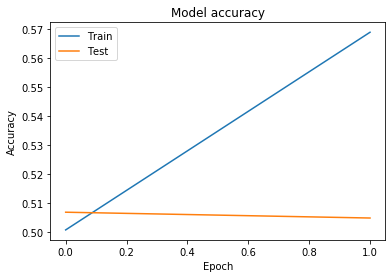

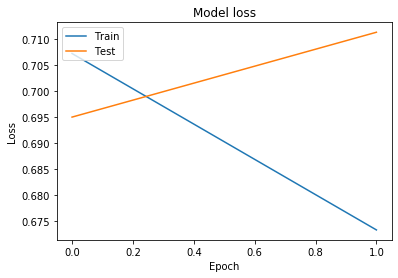


-----------------  Model Summury  ------------------------------

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_49 (Embedding)     (None, 200, 128)          12800000  
_________________________________________________________________
simple_rnn_40 (SimpleRNN)    (None, 200, 200)          65800     
_________________________________________________________________
simple_rnn_41 (SimpleRNN)    (None, 200, 200)          80200     
_________________________________________________________________
simple_rnn_42 (SimpleRNN)    (None, 200)               80200     
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 201       
Total params: 13,026,401
Trainable params: 13,026,401
Non-trainable params: 0
_________________________________________________________________
None

------------------------- Evaluati

In [143]:
#================== Create model ================
model =  createModel(1,3)
#================== Train model ================
model,_ = trainModel(5,model,lr)
#================== eval model ================
loss_ci, acc_ci = evalModel(5,model)

# ============================= Model 6 ========================

In above model with 2 layer of RNN perform better hence continuing with it

In [148]:
#========================================= Create and saving word2vec model ============================
path = get_tmpfile("word2vec.model")
model_w2v = Word2Vec(train_df['X'], size=100, min_count=10, workers=multiprocessing.cpu_count())
model_w2v.save("word2vec.model")
model_w2v = Word2Vec.load("word2vec.model")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
#============================== Creating both model i.e cbow and skipgram ========================== #
min_count = 2
model = models.Word2Vec(train_df['X'], min_count=min_count, size=100, workers=multiprocessing.cpu_count(), sg=0)

In [171]:
#============================ Creating data for training===============
def calculateWeightedAvg(X=None, wt=None):
        ll = np.array(wt).reshape(-1,1)
#         print(wt)
#         print(ll)
        # res = np.multiply(ll,np.array(X))
#         print(res)
        res=np.mean(ll, axis=0)
        # res = np.sum(res, axis=0)/np.sum(wt)
#         print(res)
        return res.tolist()


modeldata = []
for doc in train_df['X']:
    #take weighted avg. of each word in doc to find document vector
    wvlist = []
    count = []
    for word in doc:
        try: #if presend in model dict
            wvlist.append(model.wv[word])
            count.append(model.wv.vocab[word].count)
        except:
            pass
    modeldata.append(calculateWeightedAvg(wvlist, count))


modeldatatest = []
for doc in test_df['X']:
    #take weighted avg. of each word in doc to find document vector
    wvlist = []
    count = []
    for word in doc:
        try: #if presend in model dict
            wvlist.append(model.wv[word])
            count.append(model.wv.vocab[word].count)
        except:
            pass
    modeldatatest.append(calculateWeightedAvg(wvlist, count))

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(modeldata, train_df['Y'], test_size=0.8, random_state=1)
X_test = modeldatatest
Y_test = test_df['Y']

In [0]:
input_size = len(X_train[0])
#================== Create model ================
model =  createModel(1,2,1,input_size)
#================== Train model ================
model,_ = trainModel(6,model,lr)
#================== eval model ================
loss_ci, acc_ci = evalModel(6,model)

# ============================= Printing Table ====================

In [198]:
print('model',"\t",'TotalNoPara',"\t",'TrainingTime',"\t\t",'TrainingAccuracy',"\t\t",'ValidationAccuracy',"\t",'TestAccuracy')
for i in range(1,7):
  print(i,"\t",TotalNoPara[i],"\t\t","{0:.2f}".format(TrainingTime[i]),"\t\t",TrainingAccuracy[i],"\t\t",ValidationAccuracy[i],"\t\t",TestAccuracy[i])

model 	 TotalNoPara 	 TrainingTime 		 TrainingAccuracy 		 ValidationAccuracy 	 TestAccuracy
1 	 12866001 		 148.70 		 0.6254 		 0.5032 		 0.52432
2 	 13063401 		 429.55 		 0.5026 		 0.4896 		 0.5
3 	 12997601 		 336.30 		 0.5258 		 0.5032 		 0.50116
4 	 12946201 		 250.08 		 0.64575 		 0.5466 		 0.54384
5 	 13026401 		 386.43 		 0.52805 		 0.5068 		 0.49832
6 	 13016401 		 348.43 		 0.45805 		 0.4568 		 0.4183
